# Исследование надёжности заёмщиков

## Содержание
1. [Описание проекта](#project_desctryption)
2. [Обзор данных](#data_overview)
3. [Предобработка данных](#data_prepare)<br>
    3.1 [Поиск пропусков](#na_search)<br>
    3.2 [Работа с артефактами и аномалиями в данных](#art_fix)<br>
    3.3 [Поиск пропусков в столбце с ежемесячным доходом - `total_income`](#na_find_total_income)<br>
    3.4 [Поиск дубликатов](#duobl_find)<br>
4. [Категоризация данных и работа с гипотезой](#analis)
5. [Ответы на вопросы](#questions)
5. [Итоги исследования](#resume)

## Описание проекта <a name="project_desctryption"></a>

Заказчик — кредитный отдел банка.

**Цель исследования —** проверить гипотезу:

<span style="color:red">**влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок**.</span><a name= "hypothesis"> </a>

**Входные данные от банка** — статистика о платёжеспособности клиентов (файл `/datasets/data.csv`).
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

У нас есть общая информация о входных данных, разберём их далее. Исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Проверка гипотезы.

## Обзор данных <a name="data_overiew"></a>

Прочитаем файл с данными и сохраним его в переменную `df`

In [1]:
import pandas as pd        # импортируем библиотеку pandas
import seaborn as sps      # импортируем библиотеку seaborn
from matplotlib import pyplot as plt # импортируем библиотеку для построения графиков
import numpy as np # импортируем библиотеку numpy для отдельного использования функции nympy.mean () в главе 5

try:
    df = pd.read_csv('/datasets/data.csv') # чтение файла при выполнении задания в окружении Яндекса
except:
    df = pd.read_csv('data.csv') # чтение файла в локальном окружении на JupyterLab Server

Ознакомимся с данными, рочитав первые 10 строк таблицы:

In [2]:
df.head(10) # Чтение первых 10 строк датафрейма

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Получим общие данные о таблице:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Итак, у нас 12 столбцов с типами данных `int64`, `float64` и `object`.

Обратим внимание на количество ненулевых значений - в таблице есть пропуски в столбцах `days_employed` и `total_income`.

По названиям столбцов и значениям первых строк опишем значения каждого столбца, это пригодится в ориентировании и понимании, какие данные представлены для нашего исследования:

* `children` - количество детей в семье;
* `days_employed` - общий трудовой стаж в днях (очевидно - используется банком как показатель надежности клиента);
* `dob_years` - возраст клиента в годах ("dob" - "date of birth", англ.);
* `education` - образование клиента;
* `education_id` - идентификатор уровня образования - некая категория уровня образования клиента;
* `family_status` - семейное положение;
* `family_status_id` - идентификатор семейного положения - категория семейного статуса;
* `gender` - пол клиента;
* `income_type` - тип занятости клиента;
* `debt` - задолженность клиента. Показывает, имел ли клиента задолженность по возврату кредитов;
* `total_income` - ежемесячный доход;
* `purpose` - цель получения кредита.

Проверим, есть ли нарушения в стилях заголовков:

In [4]:
df.columns # выведем названия столбцов таблицы

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Нарушения стилей заголовков таблицы нет, уже хорошо. Однако в самих данных видны нарушения стилей (заглавные буквы чередуются со строчными, присутствуют отрицательные числовые значения и пропуски). Постараемся найти все аномалии в данных и исправить их на этапе предобработки.

**Выводы**

В каждой строке таблицы - данные о клиенте банка, которых хочет взять кредит на определенные нужды. Часть колонок описывает нам самого клиента - его возраст, пол, семейное положение, количество детей, образование, род деятельности, количество отработанных дней и источник дохода. Другая часть - уровень дохода, текущий долг перед банком, а также цель получения кредита. 

В таблице присутствуют столбцы, которые содержат категориальные данные - уровень образования, разбитый на категории, а также семейный статус.<br>
По всей видимости, данная категоризация упрощает работу программы кредитного скоринга для оценки кредитных рисков клиента банка.

## Предобработка данных <a name="data_prepare"></a>

### Поиск пропусков <a name="na_search"></a>

Найдем пропущенные значения в данных (в предыдущем разделе мы обнаружили 2 столбца с пропущенными значениями, проверим себя, ничего ли не пропустили):

In [5]:
df.isna().sum() # подсчёт пропущенных значений

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Действительно, два столбца (`days_employed` и `total_income`) содержат по 2174 пропущенных значения. 

Эти столбцы содержат количество отработанных дней и ежемесячный доход. Возможно, эти пропуски неслучайны - это одни и те же строки, которые соответствуют клиентам, которые не указали доход по причине отсутствия отработанных дней. Надо это проверить.

Выведем первые 10 строк датафрейма, в которых значение поля `total_income` пропущено:

In [6]:
df[df['total_income'].isna()].head(10) # выведем первые 10 строк таблицы, в которой ежемесячный доход `total_income` не заполнен

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Выясним, находятся ли пропущенные значения в найденных столбцах в одних и тех же строках.
Для этого воспользуемся логическим `И` *(AND, &)* - найдем строки где пропуски находятся и по полю `days_employed`, и по полю  `total_income`. если количество будет равным 2174, значит все пропущенные значения находятся на одних и тех же строках.

In [7]:
df[(df['total_income'].isna()) & (df['days_employed'].isna())].shape[0] # выводим количество строк в датафрейме,
                                                                        # где 'total_income' и 'days_employed'
                                                                        # пустые

2174

Теперь можно уверенно сказать, что наше предположение оказалось верным, эти пропуски неслучайны и значения `total_income` и `days_employed` пропущены в одних и тех же строках датафрейма.

Какова возможная причина этих пропусков?<br>
У клиентов пропущено количество отработанных дней и общая сумма доходов. Возможно, несколько причин, например:
* работают сами на себя (например, фриланс);
* не работают (студенты, пенсионеры);
* по каким-то причинам не хотят раскрывать свой доход и стаж;
* технические причины - ошибка при вводе данных в базу (маловероятно, но всегда возможен человеческий фактор, либо сбой работы техничесих средств обработки первичных данных, которыми наполянется база).

Проверим, можно ли принебречь данными, содержащих пропущенные значения. <br>
Подсчитаем, какую долю составляют пропущенные значения в каждом из столбцов (для удобного восприятия сразу умножим полученное значение на 100):

In [8]:
round(df['total_income'].isna().sum() * 100 / len(df), 2)   # разделим сумму строк таблицы, где 'total_income'
                                                            # пропущено (NaN), на общее количество строк таблицы
                                                            # и умножим результат на 100 для удобства,
                                                            # округлим полученное значение до 2 знаков после запятой

10.1

Получается, что 10% записей в таблице имеют пропуски, тем не менее для нашей [*гипотезы*](#hypothesis) эти данные важны, поскольку содержат информацию о количестве детей и семейном положении. <br>
Принебрегать такими данными нельзя. Займемся их обработкой позже.

### Работа с артефактами и аномалиями в данных <a name= "art_fix"> </a>

Посмотрим на каждый из столбцов для выявления аномалий.

Возьмем первый столбец.

#### Количество детей - `children`

In [9]:
df.value_counts('children') # считаем количество уникальных значений по столбцу `children` - количество детей

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
dtype: int64

Мы видим 47 строк со значениями `-1`, 76 строк со значениями `20`. Таких строк совсем мало, они врядли повлияют на результат исследование. Тем не менее, заменим значение -1 на 1, а 20 на 2 (скорее всего при вводе значения с количеством детей произошла техническая ошибка.<br>
Не будем удалять строки с данными значениями, присоединим их к наиболее многочисленному множеству.

In [10]:
df.loc[df['children'] == -1, 'children'] = 1 # если в столбце 'children' равен -1 заменяем все значения на 1
df.loc[df['children'] == 20, 'children'] = 2 # если в столбце 'children' равен 20 заменяем все значения на 2

Проверим результат

In [11]:
df.value_counts('children')

children
0    14149
1     4865
2     2131
3      330
4       41
5        9
dtype: int64

Приведем тип данных к integer для небольшой экономии памяти:

In [12]:
df['children'] = df['children'].astype(int)
df['children'].dtype

dtype('int64')

Здесь аномалий больше нет, теперь к следующему столбцу:

#### Трудовой стаж в днях - `days_employed`:

In [13]:
df.value_counts('days_employed').sort_values()

days_employed
-18388.949901     1
-15835.725775     1
-15785.678893     1
-15773.061335     1
-15618.063786     1
                 ..
 401458.877781    1
 400147.947311    1
 401446.446720    1
 401161.158251    1
 401755.400475    1
Length: 19351, dtype: int64

Среди значений общего трудового стажа в днях есть числа меньше нуля, так быть не должно. Посмотрим, сколько таких значений и в чем возможная причина такой записи:

In [14]:
days_employed_subzero_count = df[df['days_employed'] < 0]['days_employed'].count() # считаем 'days_employed'
                                                                                   # меньше 0 и выводим на экран

print(f'Количество дней меньше нуля - {days_employed_subzero_count}, что составляет ' 
        f'{days_employed_subzero_count / len(df):.0%} процента от общего количества значений столбца') # делим количество отрицательных значений
                                                                                                # `days_employed` на общее количество записей

Количество дней меньше нуля - 15906, что составляет 74% процента от общего количества значений столбца


In [15]:
print(f'''
      Минимальное отрицательное значение стажа:'
      {df[df['days_employed'] < 0]['days_employed'].min()}
      
      Максимальное отрицательное значение стажа:
      {df[df['days_employed'] < 0]['days_employed'].max()}
      
      Медианное отрицательное значение стажа:
      {df[df['days_employed'] < 0]['days_employed'].median()}''') # считаем минимум, максимум и медиану 
                                                                  # отрицательных значений 'days_employed'


      Минимальное отрицательное значение стажа:'
      -18388.949900568383
      
      Максимальное отрицательное значение стажа:
      -24.14163324048118
      
      Медианное отрицательное значение стажа:
      -1630.0193809778218


In [16]:
print(f'''
      Минимальное положительное значение стажа:'
      {df[df['days_employed'] > 0]['days_employed'].min()}
      
      Максимальное положительное значение стажа:
      {df[df['days_employed'] > 0]['days_employed'].max()}
      
      Медианное отрицательное значение стажа:
      {df[df['days_employed'] > 0]['days_employed'].median()}''') # считаем минимум, максимум и медиану 
                                                                  # положительных значений 'days_employed'


      Минимальное положительное значение стажа:'
      328728.72060451825
      
      Максимальное положительное значение стажа:
      401755.40047533
      
      Медианное отрицательное значение стажа:
      365213.3062657312


Начало трудоспособного возраста гражданина - 18 лет. Возраст выхода на пенсию для мужчин - 65 лет. 
Таким образом, найдем примерный максимум возможных отработанных дней (работающих пенсионеров не будем учитывать, найдем лишь приближение к максимуму трудового стажа в днях):

In [17]:
(65 - 18) * 365 # считаем разницу возраста начала и окончания максимального трудового стажа и умножаем  
                # на количество дней в году

17155

Полученное значение наиболее близки к максимальному по модулю значению максимального стажа среди отрицательных (|-1630.019| = 1630.019).

Можно сделать вывод о том, что, скорее всего, отрицательные значения в `days_employed` должны быть положительными, поскольку минимум, максимум и медиана **по модулю** вполне укладываются в значения возможных отработанных дней большинства людей.

К сожалению, такого нельзя сказать о положительных значениях столбца `days_employed`. С ними явно что-то не так, и нам надо постараться найти  аномалии и закономерности в них.

Количество отработанных дней, как правило, кореллирует с возрастом человека. Создадим новый датафрейм, включив в него значения `days_employed` больше нуля (поскольку они явно аномальные) и `dob_years` (возраст клиента):

In [18]:
df_big_days = df.loc[df['days_employed'] > 0, ['days_employed', 'dob_years']] # `df_big_days` содержит два столбца - `days_employed` > 0 и 
                                                                              # `dob_years` - возраст клиента

Поскольку возраст клиента указан в годах, а общий трудовой стаж в днях, переведем это значение в годы для удобства восприятия и дальнейшего анализа:

In [19]:
df_big_days['years_employed'] = df_big_days['days_employed'] / 365   # создаем новый столбец `years_employed` с отработанным временем в годах
df_big_days = df_big_days.drop('days_employed', axis=1)              # удаляем столбец `days_employed`, поскольку он нам больше не нужен

In [20]:
df_big_days.sort_values('dob_years')  # посмотрим, что получилось, отсортируем новый датафрейм с большим количеством отработанных дней 
                                     # по возрасту клиента

,dob_years,years_employed
4922,0,921.961660
15886,0,974.913109
20577,0,908.880196
1175,0,1016.108241
12729,0,972.903359
...,...,...
6406,73,965.040547
3460,74,944.174893
4895,74,935.693496
19642,74,1041.507910


У нас есть нулевые значения `dob_years` Они могут испортить статистику, если их количество мало, удалим их из датафрейма:

In [21]:
df_big_days[df_big_days['dob_years'] == 0]['dob_years'].count() # подсчитаем количество строк df_big_days, где `dob_years` равно нулю

17

Таких значений всего 17, удалим их из датафрейма `df_big_days`

In [22]:
df_big_days = df_big_days[df_big_days['dob_years'] > 0] # объявляем df_big_days, который содержит возраст клиента `dob_years` больше нуля 

Построим парный график для визуализации значений, которые мы получили:

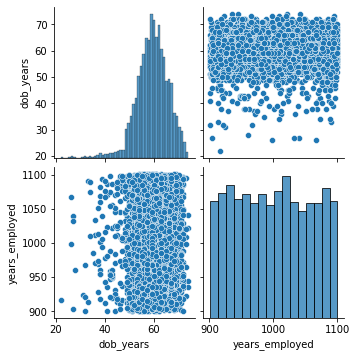

In [23]:
sps.pairplot(df_big_days)  # строим парный график для визуализации данных с аномалиями

По графику видно, что больше всего аномалий по трудовому стажу в годах сосредоточена в возрастной категории примерно 45 - 75 лет.
Сузим границы и построим график-гистограмму распределения этих значений:

<AxesSubplot:xlabel='dob_years', ylabel='years_employed'>

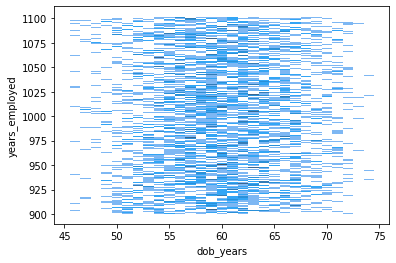

In [24]:
sps.histplot(df_big_days[df_big_days['dob_years'] > 45], x='dob_years', y='years_employed', discrete=(True, True)) # строим гистограмму, где 
                                                                                                                   # по оси X - возраста старше 45, 
                                                                                                                   # а по Y - аномальный трудовой стаж

Очень похоже на нормальное распределение, в нашем случае распределение отработанных лет по возрастам от 45 до 75 лет.<br>
Судя по всему, аномалии с отработанными днями носят случайный характер, а их количество по возрастам поддаётся нормальному распределению. Нужно проверить, как распределяется трудовой стаж относительно возраста на неискаженных данных, сделаем это чуть [*позже*](#alloc).
Поскольку значения параметра `days_employed` не важны в нашем исследовании, можно не восстанавливать значения указанного параметра, а заменить аномальные значения на медианное для данной возрастной категории в тех данных, которые без аномалий. Остальную (ту часть, что не укладывается в возрастной диапазон от 45 до 75 лет) заменим на медианное значение всего датасета.

Итак, пойдем в следующем порядке:
* отрицательные значения сделаем положительными;
* округлим значения дней до 0 знаков после запятой;
* заменим все пропуски в датасете на медианное значение;
* приведем столбец `days_employed` к типу `integer`;
* заменим все большие значения `days_employed` (минимальная граница начала диапазона больших значений была найдена ранее - `328728`) в возрастной категории больше 45 лет (`dob_years > 45`) на медианное значение остального датасета той же возрастного диапазона.


In [25]:
df['days_employed'] = round(abs(df['days_employed'])) # столбец 'days_employed' приводим к положительному значению (берем по модулю)
                                                      # и округляем

In [26]:
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median())  # заменяем пропущенные значения на медианное и
df['days_employed'] = df['days_employed'].astype(int)                           # приводим значения столбца `days_employed` к integer
df['days_employed'].head()                                                      # проверяем, что все значения `days_employed` стали натуральными

0      8438
1      4025
2      5623
3      4125
4    340266
Name: days_employed, dtype: int64

Посмотрим на медиану всего получившегося столбца `days_employed`:

In [27]:
df['days_employed'].median() # находим медианное значение значений столбца с трудовым стажем клиентов в днях - `days_employed`

2194.0

Отлично. Теперь найдем медиану для всех значений `days_employed` возрастной группы больше 45 лет.

In [28]:
days_employed_dob_years_above_45_median = df[(df['dob_years'] > 45) & (df['days_employed'] < 328728)]['days_employed']  \
    .median() # сохраняем медиану в отдельную переменную days_employed_dob_years_above_45_median и выводим её

In [29]:
df.loc[df['days_employed'] > 328728, 'days_employed'] = days_employed_dob_years_above_45_median # меняем все большие значения на медианные 
                                                                                                # той же возрастной категории
df['days_employed'].median()  # выводим медиану

2194.0

Медиана не изменилась. Теперь посмотрим, как выглядит распределение занчений отработанных дней относительно возраста клиентов:<a name="alloc"></a>

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

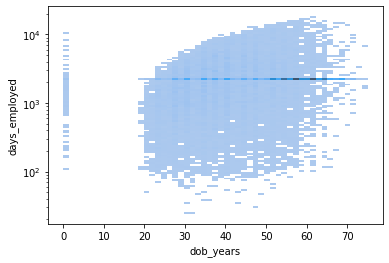

In [30]:
sps.histplot(df, x='dob_years', y='days_employed', log_scale=(False, True))

**Промежуточный итог обработки** `days_employed`:
* в целом, распределение отработанных дней прямо пропорциональна возрасту клиентов;
* четко выражена медиана;
* видны значения при возрасте около нуля, займемся обработкой этих значений далее.


Со столбцом `days_employed` можно закночить и пойти дальше.

 #### Возраст клиента в годах - `dob_years`

Выведем количество уникальных значений столбца `dob_years`:

In [31]:
df['dob_years'].sort_values().unique() # выводим отсортированные по возрастанию уникальные значения `dob_years`

array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

Подсчитаем количество записей, где `dob_years` равно нулю, и долю этих значений (в процентах) относительно общего количества записей таблицы:

In [32]:
print(f"""Количество записей, где возраст клиента ноль равно: {df[df['dob_years'] == 0]['dob_years'].count()}, 
что составляет {(df[df['dob_years'] == 0]['dob_years'].count() / len(df)):%}""")

Количество записей, где возраст клиента ноль равно: 101, 
что составляет 0.469222%


Эти данные составляют меньше 0.5% от общего количества записей датафрейма. Этими значениями можно принебречь в нашем исследовании. 

Удалим эти строки.

In [33]:
df = df[df['dob_years'] != 0] # сохраняем датафрейм, заменяее его им же, в котором `dob_years` не ноль

Перейдем к следующему столбцу.
#### Образование -  `education`. 
Посмотрим, какие уникальные значения хранит этот столбец.

In [34]:
df['education'].unique() # выводим уникальные значения `education`

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

В столбце имеются значения в разном регистре, приведем их к нижнему регистру:

In [35]:
df['education'] = df['education'].str.lower() # приводим все значения в `education` к нижнему регистру
df['education'].unique()                      # и выводим полученные значения

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Данные выглядят корректно. Переходим к столбцу `education_id`. Посмотрим, какие значения содержит он.

In [36]:
df['education_id'].unique() # выводим уникальные значения `education_id`

array([0, 1, 2, 3, 4])

Этот столбец, по всей видимости, хранит категориальные данные. Количество уникальных элементов `education` равно количеству уникальныхъ элементов `education_id`.
Проверим это предположение позже на  [*этапе обработки категориальных данных*](#analis).

Посмотрим на следующий столбец.

#### Сеейный статус - `family_status`. 
Найдем уникальные значения этого столбца:

In [37]:
df['family_status'].unique() # выводим уникальные значения `family_status` - семейный статус

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

В этом столбце есть значение, которое начинается с заглавной буквы - *`Не женат / не замужем`*. В остальном аномалий нет.<br>
Приведем все значения столбца к нижнему регистру:

In [38]:
df['family_status'] = df['family_status'].str.lower() # Приводим `family_status` к нижнему регистру
df['family_status'].unique()                          # Проверяем результат - выводим уникальные значения столбца

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

Перейдем к следующему столбцу - `family_status_id`. Посмотрим на его уникальные значения:

In [39]:
df['family_status_id'].unique() # выводим уникальные значения столбца `family_status_id`

array([0, 1, 2, 3, 4])

Этот столбец, по всей видимости, хранит категориальные данные. Количество уникальных элементов `family_status` равно количеству уникальныхъ элементов `family_status_id`.
Проверим это предположение *[позже](#analis)*.

Далее, проверим следующий столбец
#### Пол клиента - `gender`:

In [40]:
df['gender'].unique() # выводим уникальные значения столбца `gender`

array(['F', 'M', 'XNA'], dtype=object)

Уникальных значений три: с *`F`* и *`M`* всё понятно, но есть неопределенный *`XNA`*. Посомтрим, сколько таких гендеров:

In [41]:
df['gender'].value_counts() # подсчет количества уникальных значений столбца `gender`

F      14164
M       7259
XNA        1
Name: gender, dtype: int64

Такой гендер *`XNA`* всего один, это явно случайная аномалия, можно этим значением принебречь.

Удалим строку с этим значением датасета, на результат исследования одна запись не повлияет:

In [42]:
df = df[df['gender'] != 'XNA'] # заменяем текущий датафрейм тем же, в котором нет гендера 'XNA'

Выведем уникальные значения следующего столбца :
#### Источник дохода - `income_type`

In [43]:
df['income_type'].unique() # выводим уникальные значения столбца `income_type`

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

С этим столбцом всё в порядке. Перейдем дальше. 
#### `debt` - наличие задолженности:
Выведем его:

In [44]:
df['debt'].unique() # выводим уникальные значения столбца `debt`

array([0, 1])

Очевидно, что это категориальные данные, которые показывают, есть ли задолженность у клиента банка. С этим столбцом всё в порядке.

Мы избавились от артефактов и аномалий во всех категориальных данных. Вернемся к поиску пропусков и аномалий в столбце `total_income`

### Поиск пропусков в столбце `total_income` <a name="na_find_total_income"> </a>

Вернемся к столбцу `total_income`, чтобы подробно заняться пропуском данных в этом столбце. Теперь нам будет легче - мы избавились от пропусков, артефактов и аномалий в остальных столбцах.

Обратим внимание на столбец - `total_income`. В главе [Обзор данных](#data_overview) мы видели, что в столбце `total_income` присутствуют пустые значения.

In [45]:
df['total_income'].sort_values()

14585    20667.263793
13006    21205.280566
16174    21367.648356
1598     21695.101789
14276    21895.614355
             ...     
21489             NaN
21495             NaN
21497             NaN
21502             NaN
21510             NaN
Name: total_income, Length: 21423, dtype: float64

В столбце есть только положительные значения. Приведем их к типу *integer*:

In [46]:
df['total_income'] = pd.to_numeric(round(df['total_income'])) # округляем `total_income` и приводим его к целым значениям

Поскольку трудно найти взаимосвязь между ежемесячным доходом и другими данными, представленными в таблицы (это тема для отдельного исследования), заменим пропущенные значения медианным.
Посмотрим, как повлияет на столбец `total_income` замена пустых значений на медианное.

Построим график распределения ежемесячного дохода относительно количества записей и выделим отдельно медианное значение:

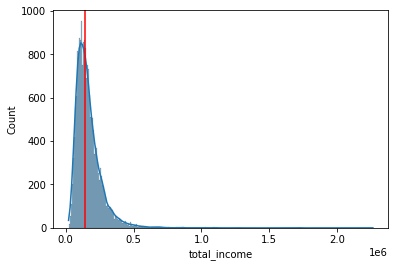

In [47]:
sps.histplot(data=df, x='total_income', kde = True) # строим распределение ежемесячного дохода (x) относительно количества таких значений (y - по умолчанию count)
plt.axvline(df['total_income'].median(), color='red') # нарисуем там же красную вертикальную линию с медианным значением дохода

Попробуем найти зависимость пропущенных значений столбца `total_income` от категориальных данных остальной таблицы:

In [48]:
df[df['total_income'].isna()].groupby('education')['education'].count() # среди строк, где 'total_income' пропущен, группируем и 
                                                                        # считаем количество по категории `education`

education
высшее                  541
начальное                21
неоконченное высшее      69
среднее                1533
Name: education, dtype: int64

Большинство клиентов, у которых пропущен ежемесячный доход - со средним и высшим образованием. Идем дальше.

In [49]:
df[df['total_income'].isna()].groupby('family_status')['family_status'].count() # среди строк, где 'total_income' пропущен, группируем и 
                                                                                # считаем количество по категории `family_status`

family_status
в разводе                 111
вдовец / вдова             94
гражданский брак          439
женат / замужем          1233
не женат / не замужем     287
Name: family_status, dtype: int64

Большинство из тех, у кого пропущено значение с ежемесячным доходом - женаты или в гражданском браке.

In [50]:
df[df['total_income'].isna()].groupby('gender')['gender'].count() # среди строк, где 'total_income' пропущен, группируем и 
                                                                  # считаем количество по категории `gender`

gender
F    1476
M     688
Name: gender, dtype: int64

И это в основном женщины. Но какое соотношение мужчин и женщин во всей таблице:

In [51]:
df.groupby('gender')['gender'].count() # подсчитаем общее количество мужчин и женщин в датафрейме

gender
F    14164
M     7259
Name: gender, dtype: int64

И тут перевес примерно 2:1, как и в нулевых значениях. На этот параметр опираться не будем.

Ещё одна категория: тип дохода - `income_type`. <br>
Подсчитаем, у клиентов каких типов источников дохода отсутствуют данные о доходе.<br>
Выведем общую таблицу:

In [52]:
# создадим Series с количеством пропущенных значений `total_income` по источникам дохода `income_type`
sr_income_type_missed = df[df['total_income'].isna()].groupby('income_type')['income_type'].count()
# создадим Series с общим количеством `total_income` по источникам дохода `income_type`
sr_income_type_total = df.groupby('income_type')['income_type'].count()

# соединим оба объекта по общему индексу:
pd.concat([sr_income_type_missed, sr_income_type_total], axis=1, keys=['Пропущенные', 'Всего'])

,Пропущенные,Всего
income_type,,
госслужащий,147.0,1453
компаньон,506.0,5064
пенсионер,410.0,3836
предприниматель,1.0,2
сотрудник,1100.0,11064
безработный,NaN,2
в декрете,NaN,1
студент,NaN,1


Видуализируем для наглядности:

<AxesSubplot:xlabel='income_type', ylabel='Count'>

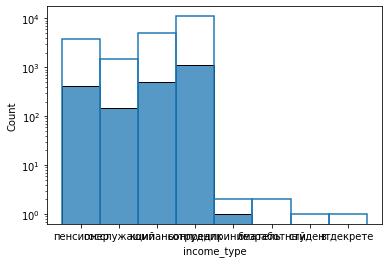

In [53]:
# сначала нарисуем диаграмму распределения количества пропущенных значений `total_income` по категориям
sps.histplot(df[df['total_income'].isna()]['income_type']) 
# поверх неё нарисуем еще одну, где уже всё количество пропущенных значений `total_income` по категориям,
# включим логарифмическую шкалу и оставим столбики незаполненными для нагляднсти
sps.histplot(df['income_type'], log_scale=(False, True), fill=False)

Получается, среди пропущенных значений распределение по категории "источник дохода" - такое же, как и во всём датафрейме. Пропущенных значений примерно в 10 раз меньше по всем категориям, и ни одна не выделяется

Полученную нами информацию можно использовать для заполнения пустых значений датафрейма медианными по каждой категории дохода.

Попробуем создать еще один столбец `total_income_fill_by_type`, в который войдут медианные значения по источнику дохода:

In [54]:
df['total_income_fill_by_type'] = df.groupby(['income_type'])['total_income'] \
    .apply(lambda x: x.fillna(x.median())) # группируем таблицу по типу дохода, 
                                    # суммируя общий доход по каждому типу, применяем лямбда функцию с заполнением
                                    # каждого пропущенного значения медианным для своей категории рода деятельности

Попробуем подсчитать по количественному параметру `dob_years` - возраст клиента в годах. Для визуализации результатов построим столбчатую диаграмму распределения

<AxesSubplot:xlabel='dob_years', ylabel='Count'>

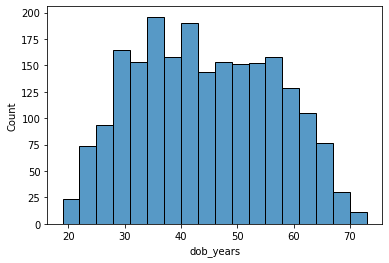

In [55]:
sps.histplot(df[df['total_income'].isna()]['dob_years']) # среди строк, где 'total_income' пропущен, визуализируем по категории `dob_years`

Большинство из тех, к у кого не заполнен ежемесячный доход - люди в возрасте примерно от 30 до 60 лет (от 0 до 20 люди в основном нетрудоспособные, количество пропущенных значений для людей от 20 до 30 лет невелико).

Теперь подсчитаем медианное значение по столбцу `total_income` с учетом следующих параметров:
* образование среднее или высшее;
* женат или в гражданском браке;
* возраст от 30 до 60 лет.

In [56]:
total_income_params_median = df[((df['education'] == 'среднее') | (df['education'] == 'высшее')  
    & ((df['family_status'] == 'женат / замужем') | (df['family_status'] == 'гражданский брак')
    & (df['dob_years'] > 30) 
    & (df['dob_years'] < 60)))]['total_income'].median() # медиана с учетом всех выявленных закономерностей

total_income_params_median

143503.0

Выведем медианное значение ежемесячного дохода всей таблицы:

In [57]:
df['total_income'].median()

145005.0

Медиана `total_income` всего датафрейма не сильно отличается от медианы, найденной нами с учетом заданных параметров.
Значит, пропущенные данные носят случайный характер и по своим характеристикам близки к медианным значениям.

Теперь создадим новый столбец `total_income_params`, в котором будут все значения из `total_income`, а пропущенные  значения столбца `total_income` будут медианным по тем параметрам, которые мы нашли выше.

Построим графики распределения для двух столбцов `total_income_params` и `total_income_fill_by_type`.<br>
Посмотрим, как сильно повлияла замена значений ежемесячного дохода на медианное:

In [58]:
df['total_income_params'] = df['total_income'].fillna(total_income_params_median) # заполняем пропуски столбца `total_income` медианным значением

Сначала построим график распределения значений для столбца `total_income_params`, а также отдельно количество медианных значений (в виде вертикальной прямой).

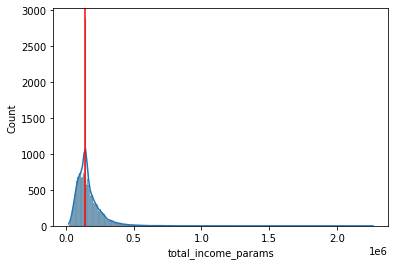

In [59]:
sps.histplot(data=df, x='total_income_params', kde = True) # строим распределение ежемесячного дохода (x) относительно количества таких значений 
# (y - по умолчанию count) по столбцу `total_income_params`

plt.axvline(df['total_income_params'].median(), color='red') # проводим красную вертикальную линию - медианное значение ежемесячного дохода

Медианное изменило распределение, сильно выделившись по количеству значений. Однако, ширина распределения остался такой же.

Теперь сделаем тоже самое по столбцу `total_income_fill_by_type`:

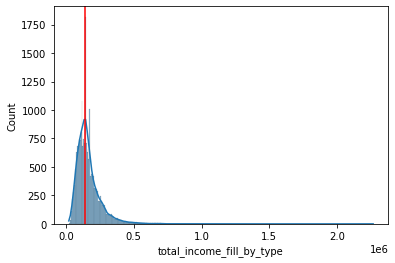

In [60]:
sps.histplot(data=df, x='total_income_fill_by_type', kde = True) # строим распределение ежемесячного дохода (x) относительно количества таких значений 
# (y - по умолчанию count) - по столбцу `total_income_fill_by_type`

plt.axvline(df['total_income_fill_by_type'].median(), color='red') # проводим красную вертикальную линию - медианное значение ежемесячного дохода

Этот график распределения по столбцу `total_income_fill_by_type` больше приближен к оригинальному до преобразований, количество медианных значений почти в 2 раза меньше аналогичного количества в столбце `total_income_params`

Мы нашли подходящий метод заполнения пропусков, временные столбцы больше не нужны. <br>
Теперь удалим `total_income_params` и `total_income_fill_by_type`, а пустые значения столбца `total_income` заполним медианными значениями для каждой категории источника дохода (роду деятельности) клиента, поскольку они меньше портят общую картину значений, не выделяют так сильно медиану.
Применим к `total_income` те же действия, что и при объявлении столбца `total_income_fill_by_type`

In [61]:
# удаляем временные столбцы.
df.drop(columns=['total_income_params', 'total_income_fill_by_type'], axis=1, inplace=True)

df['total_income'] = df.groupby(['income_type'])['total_income'] \
    .apply(lambda x: x.fillna(x.median())) # группируем таблицу по типу дохода, 
                                    # суммируя общий доход по каждому типу, применяем лямбда функцию с заполнением
                                    # каждого пропущенного значения медианным для своей категории рода деятельности

После всех преобразований и применения метода `median()` к столбцу `total_income` приведем его к типу integer:

In [62]:
df['total_income'] = df['total_income'].astype(int) # заменим вещественный тип данных столбца `total_income` на целочисленный

Посмотрим на полученную таблицу после всех преобразований:

In [63]:
df.head() # выведем первые 5 значений датафрейма

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование
4,0,2194,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


In [64]:
df.isna().sum() # подсчитаем сумму пустых значений в таблице

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод:**  Все столбцы избавлены от аномалий и пустых значений.

### Поиск дубликатов <a name="duobl_find"></a>

Посмотрим на столбец `purpose` и выведем его уникальные значения:

In [65]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В данных много уникальных значений (хорошо, что все они уже в нижнем регистре и не имеют лишних пробелов, либо аномалий), но они содержат много близких по смыслу значений (например: 'свой автомобиль', 'приобретение автомобиля'). <br>
Эти значения представляют собой категории - цели получения кредита. Обработаем их сейчас, чтобы на следующем этапе выявить больше явных дубликатов и удалить их (если уникальных значений в столбце `purpose` будет меньше, то количество возможных дубликатов - больше).

Категорий всего четыре:
* операции с автомобилем;
* операции с недвижимостью;
* проведение свадьбы;
* получение образования.

Напишем функцию, которая будет принимать на вход столбец *Series* и словарь, ключами для которого будут категории из списка выше. Функция будет искать в каждом элементе *Series* `df['purpose']` уникальные части слов (по значениям словаря) и менять все значения в столбце `purpose`, перезаписывая их на ключи исходного словаря (категории). 

In [66]:
'''
purpose_dict = {'операции с недвижимостью': ['недвиж', 'жил'],
                'получение образования': 'образ',
                'операции с автомобилем': 'авто',
                'проведение свадьбы': 'свадьб'
    
} # Создаём словарь, в котором ключами будут являться категории - цели получения кредита, а значениями - подстрока, 
  # по которым становится понятна цель кредита (именно подстрока будет целью поиска в столбце `purpose`)

def replace_from_dict(dictionary = {}, series = pd.Series): # объявляем функцию замены значений из словаря в столбце датафрейма
    for key in dictionary:   # Создаем цикл для каждого значения ключа в словаре
        if type(dictionary.get(key)) == list:        # если значение ключа - список, то
            for list_value in dictionary.get(key):   # проходим по всем элементам этого списка значений ключа
                df.loc[series.str.contains(list_value), series.name] = key # если строка в столбце содержит значение ключа, 
                                                                           # то заменяем значение строки на ключ словаря
        elif type(dictionary.get(key)) == str:     # иначе если значение ключа - строка, то
            df.loc[series.str.contains(dictionary.get(key)), series.name] = key # заменяем значение строки на ключ словаря
        else:
            return 'Ошибка определения типа значений словаря. Значения могут быть типа <list> или <str> в рамках работы данной функции.'
        
replace_from_dict(purpose_dict, df['purpose']) # вызываем нашу функцию с параметрами словаря `purpose_dict` и df['purpose'] в качестве столбца.

df['purpose'].unique() # выведем уникальные значения столбца df['purpose'], чтобы проверить результат работы функции
'''
'Код выше закомментирован, вместо него работает следующая Code-ячейка'

'Код выше закомментирован, вместо него работает следующая Code-ячейка'

In [67]:
def replace_purpose(purpose):          # функция, возвращающая категорию цели кредита в зависимости от найденных в ней ключевых лексических цепочек
    if 'образ' in purpose:
        return 'получение образования'
    elif 'авто' in purpose:
        return 'операции с автомобилем'
    elif 'свадьб' in purpose:
        return 'проведение свадьбы'
    else:
        return 'операции с недвижимостью' # если ничего не нашлось, то это операции с недвижимостью (это лаконичнее, чем перечислять ключи 'недвиж', 'жил'

df['purpose'] = df['purpose'].apply(replace_purpose)  # применим функцию к каждому элементу столбца 'purpose'

df['purpose'].unique() # выведем уникальные значения столбца df['purpose'], чтобы проверить результат работы функции

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

Мы привели значения в столбце `purpose` к единообразному виду.

Часть дубликатов найдены нами в ходе работы со столбцом `total_income`, когда мы искали зависимость пустых значений от уровня образования. Тогда было важно привести столбец `education` к единообразному виду, избавившись от дубликатов.

Теперь, после унификации всех уникальных значений во всех столбцах, избавимся от явных дубликатов. Сначала найдем их:

In [68]:
df.duplicated().sum() # подсчитаем количество дубликатов в датафрейме

404

Удалим явные дубликаты, пересоздадим индексы, удалив столбец со значением старых индексов.

In [69]:
df = df.drop_duplicates().reset_index(drop=True) # удаляем дубликаты, восстанавливаем индексы и удаляем столбец со старыми индексами

Посмотрим информацию о таблице после всей предварительной обработки:

In [70]:
df.info() # Получаем информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21019 entries, 0 to 21018
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21019 non-null  int64 
 1   days_employed     21019 non-null  int64 
 2   dob_years         21019 non-null  int64 
 3   education         21019 non-null  object
 4   education_id      21019 non-null  int64 
 5   family_status     21019 non-null  object
 6   family_status_id  21019 non-null  int64 
 7   gender            21019 non-null  object
 8   income_type       21019 non-null  object
 9   debt              21019 non-null  int64 
 10  total_income      21019 non-null  int64 
 11  purpose           21019 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.9+ MB


Выведем 5 случайных значений таблицы, чтобы посмотреть на результат:

In [71]:
df.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
15492,0,1069,29,высшее,0,женат / замужем,0,F,сотрудник,0,195430,операции с недвижимостью
8910,1,805,47,высшее,0,женат / замужем,0,F,сотрудник,0,434872,операции с автомобилем
12282,2,923,44,среднее,1,гражданский брак,1,F,сотрудник,1,442278,проведение свадьбы
5269,0,2392,28,среднее,1,гражданский брак,1,F,сотрудник,0,114621,проведение свадьбы
3004,0,1394,50,среднее,1,гражданский брак,1,M,сотрудник,0,266916,операции с автомобилем


## Категоризация данных и работа с гипотезой <a name="analis"></a>

Создадим два новых датафрейма, в которых:
* каждому уникальному значению из `education` соответствует уникальное значение `education_id` — в первом;
* каждому уникальному значению из `family_status` соответствует уникальное значение `family_status_id` — во втором.

In [72]:
df_education = df[['education','education_id']]    # создаем новую таблицу `df_education`, которая содержит столбцы 'education' и'education_id'
df_education = df_education.drop_duplicates().reset_index(drop=True)  # удаляем дубликаты из новой таблицы
df_education               # выводим новую таблицу df_education

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [73]:
df_family = df[['family_status','family_status_id']]    # создаем новую таблицу `df_family`, которая содержит столбцы 'family_status' и'family_status_id'
df_family = df_family.drop_duplicates().reset_index(drop=True)  # удаляем дубликаты из новой таблицы
df_family               # выводим новую таблицу df_family

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


В каждой из таблиц `df_education` и `df_family` у нас по 5 уникальных категорий.<br>
Теперь удалим из исходного датафрейма столбцы `education` и `family_status`, оставив только их идентификаторы: `education_id` и `family_status_id`.<br>
Новые датафреймы — это «словари», к которым мы сможем обращаться по идентификатору.

In [74]:
df.drop(['education','family_status'], axis=1, inplace=True) # удаляем столбцы 'education','family_status' без необходимости переназначения df 
                                                                # (изменяем существующий параметром inplace)

На основании диапазонов, указанных ниже, создадим столбец `total_income_category` с категориями:
* 0–30000 — 'E';
* 30001–50000 — 'D';
* 50001–200000 — 'C';
* 200001–1000000 — 'B';
* 1000001 и выше — 'A'.

Для этого создадим функцию `total_income_group(income)`, которая оценивает ежемесячный доход клиента и возвращает группу, которой клиент принадлежит

In [75]:
def total_income_group(income):
    if income <= 30000:
        return 'E'
    elif 30001 <= income <= 50000:
        return 'D'
    elif 50001 <= income <= 200000:
        return 'C'
    elif 200001 <= income <= 1000000:
        return 'B'
    else:
        return 'A'

Создадим в датафрейме `df` новый столбец `total_income_category`, в который поместим результат выполнения функции `total_income_group` по столбцу `total_income`:

In [76]:
df['total_income_category'] = df['total_income'].apply(total_income_group) # создаем новый столбец `total_income_category`,
                                                                           # который содержит категории клиентов по ежемесячному доходу

Теперь по условиям задачи мы должны создать функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:
* операции с автомобилем;
* операции с недвижимостью;
* проведение свадьбы;
* получение образования.

Мы это уже сделали на этапе работы с дубликатами, перезаписав сам столбец `purpose`, тем самым выявив больше дубликатов, чем мы могли выявить, если бы создали дополнительный столбец, а также сэкономили память, выделяемую на хранение датафрейма и время обработки датафрейма. <br>

*Примечание 1: Можно создать еще одну таблицу с категориями целей выдачи кредита, сэконовим еще память и ресурсы, но это не входит в задачи данного проекта.*

*Примечание 2: Предварительный подсчет показал 404 явных дубликатов с приведением самого столбца `purpose` против 71 явного дубликата без приведения этого столбца к отдельным категориям, а созданием дополнительного столбца `purpose_category`. Данная работа не вошла в проект, поскольку проводилась отдельно, иначе это бы сильно увеличило исследование.*

## Ответы на вопросы <a name="questions"></a>

Пора проанализировать полученные данные и ответить на следующие вопросы:
1. [Есть ли зависимость между количеством детей и возвратом кредита в срок?](#q1)
2. [Есть ли зависимость между семейным положением и возвратом кредита в срок?](#q2)
3. [Есть ли зависимость между уровнем дохода и возвратом кредита в срок?](#q3)
4. [Как разные цели кредита влияют на его возврат в срок?](#q4)

<a name="q1"></a>*Начнем с первого*. Определим, есть ли зависимость между количеством детей и возвратов кредита в срок. 
Для этого во-первых подсчитаем количество должников, сгруппировав их по количеству детей, а также количество всех клиентов по возрастам:

In [77]:
# группируем всех клиентов по количеству детей, применяем агрегацию 
df_grouped_children_debt = df.groupby('children')['debt'].agg(Sum='sum', Count='count')
# двух функций, где Sum - сумма всех должников ('debt'=1), Count = их количество,
# сохраняем это в новый детефрейм df_grouped_children_debt
df_grouped_children_debt

,Sum,Count
children,,
0,1056,13760
1,442,4782
2,202,2101
3,27,327
4,4,40
5,0,9


Мы получили абсолютные значения. Но они могут быть нерепрезентативными, поскольку количество клиентов неравномерно распределено относительно количества детей.<br>
Подсчитаем относительные значения должников по количеству детей, разделив сумму должников на общее количество по возрастным категориям:

<AxesSubplot:xlabel='children', ylabel='Mean'>

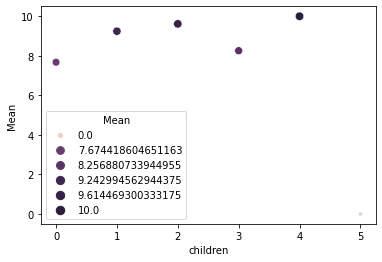

In [78]:
# считаем должников от общего колдичества клинетов по возрастным группам
df_grouped_children_debt['Mean'] = df_grouped_children_debt['Sum'] / df_grouped_children_debt['Count'] * 100 
# построим диаграмму распределения количества детей от относительного числа должников
sps.scatterplot(x='children', y='Mean', data=df_grouped_children_debt, size='Mean', hue='Mean') 

Относительные данные вполне показательны.
Можно сделать вывод, что записимость количества детей от возврата кредита в срок есть (на мой взгляд, несущественная). <br>
Среди клиентов с двумя и четырьмя детьми должников больше всего в относительном выражении.<br>
А среди клиентов с пятью деньми должников нет, но таких клиентов всего 9 человек - людей с таким большим количеством детей мало.

Подкрепим диаграмму распределения сводной таблицей:

In [79]:
# строим сводную таблицу, считая должников (sum) и общее число клиентов (count), группируя по количесту детей
pivot_children = df.pivot_table(index='children', values='debt', aggfunc=['sum', 'count']) 

pivot_children['%'] = round(pivot_children['sum'] / pivot_children['count'] * 100, 2) # добавляем процент должников от общего числа плиентов

pivot_children.sort_values('%') # выводим, сортируя от меньшего относительного значения к большему - как на диаграмме распределения выше

,sum,count,%
,debt,debt,
children,,,
5,0,9,0.00
0,1056,13760,7.67
3,27,327,8.26
1,442,4782,9.24
2,202,2101,9.61
4,4,40,10.00


<a name="q2"></a> *Перейдем ко второму вопросу:* есть ли зависимость между семейным положением и возвратом кредита в срок?<br>
Для этого сгруппируем наши данные по семейному статусу `family_status_id` и подсчитаем среднее количество должников от общего числа клиентов и посмотрим на получившийся результат.

In [80]:
# группируем датафрейм по семейному статусу, считаем среднее количество должников относительно общего числа клиентов.
# затем присоединяем датафрейм-"словарь" с семейными статусами df_family
df.groupby('family_status_id')['debt'] \
    .agg(Mean='mean') \
    .merge(right=df_family, on='family_status_id', how='left') \
    .sort_values(by='Mean', ascending=False)

,family_status_id,Mean,family_status
4,4,0.098627,не женат / не замужем
1,1,0.094100,гражданский брак
0,0,0.076904,женат / замужем
3,3,0.071851,в разводе
2,2,0.066098,вдовец / вдова


Можно сделать вывод, что количество неженатых клиентов или клиентов в гражданском браке реже возвращают кредит в срок, чем клиенты остальных категорий.

<a name= "q3"></a> *Следующий вопрос:* есть ли зависимость между уровнем дохода и возвратом кредита в срок?<br>
Сделаем группировку по `total_income_id`, подсчитав среднее количество должников от общего числа:

In [81]:
df.groupby('total_income_category')['debt'] \
    .mean() \
    .sort_values(ascending=False) * 100 # группируем датафрейм по категории дохода 
# и считаем количество должников, умножим на 100 и отсортируем по убыванию для наглядности

total_income_category
E    9.090909
C    8.655263
A    8.000000
B    7.078764
D    6.034483
Name: debt, dtype: float64

Клиенты с самым низким доходом (категория *`E`* - до 30000) реже всех возвращают кредит в срок. А вот следующая категория - *`D`* (от 30001 до 50000) возвращают кредит в срок чаще остальных.

<a name="q4"></a>*Ответим на последний вопрос:* как разные цели кредита влияют на его возврат в срок?
Для этого сгруппируем категории выдачи кредита и подсчитаем среднее количество должников:

In [82]:
# группируем таблицу по цели выдачи кредита, считаем среднее значение поля `debt` - среднее количество должников в каждой категории,
# затем сортируем по убыванию
df.groupby('purpose')['debt'] \
    .mean() \
    .sort_values(ascending=False) * 100

purpose
операции с автомобилем      9.388235
получение образования       9.376584
проведение свадьбы          8.027923
операции с недвижимостью    7.387712
Name: debt, dtype: float64

Можно сделать вывод, что разные цели кредита влияют на его возврат в срок - реже всего возвращают в срок кредиты, выданные на операции с автомобилем и на получение образования. Чаще всего - кредиты, полученные на операции с недвижимостью.

Для окончательной проверки [*гипотезы*](#hypothesis) построим сводную таблицу, сгруппировав клиентов по количеству детей и семейному положению, подсчитав среднее значение должников (в процентах):

In [83]:
# присоединяем таблицу df_family, склеивая ее по `family_status_id`, включая id из левой таблицы в итоговую,
# строим сводную таблицу, где группировка по количеству детей - `children`; в качестве значений, которым будет происходить группировка - 
# `family_status` - семейный статус из таблицы df_family, в качестве значений таблицы - среднее количество должников (их сумма / общее количество
# клиентов той же категории.
# Для удобства восриятия, умножим средние значения на 100, чтобы получить процент должников от общего числа клиентов той же категории - 
# для этого используем lambda функцию. Пропуски заполним нулями
df.merge(right=df_family, on='family_status_id', how='left') \
    .pivot_table(index='children',
        columns='family_status',
        values='debt',
        aggfunc=lambda x: np.mean(x*100),
        fill_value=0
)

family_status,в разводе,вдовец / вдова,гражданский брак,женат / замужем,не женат / не замужем
children,,,,,
0,7.096774,6.295400,8.426132,7.069870,9.446694
1,6.666667,8.641975,11.919192,8.322011,11.283186
2,9.876543,12.500000,9.375000,9.481102,12.048193
3,9.090909,0.000000,14.285714,6.910569,12.500000
4,0.000000,0.000000,0.000000,10.714286,50.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000


Можно сделать промежуточный вывод о том, что больше всех долгов имеют неженатые клиенты с четырьмя детьми.<br>
Но их самих, таких клиентов, не так уж и много:

In [84]:
df[(df['children'] == 4) & (df['family_status_id'] == 4)]['children'].count() # выбираем клиентов, у которых 4 детей и статусемейный статус
# не женат / не замужем - `family_status_id` = 4, и считаем их количество

2

Всего двое, один из которых - не платит вовремя по кредиту. <br>
Получается, представление данных с использованием только относительных значений - не репрезентативно.

С учетом этого построим тепловую карту, используя не относительные, а абсолютные значения количества должников:

<AxesSubplot:xlabel='family_status', ylabel='children'>

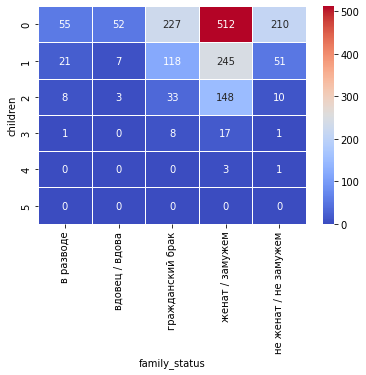

In [85]:
# строим хитмэп, данными для которого является сводная таблица по параметрам из таблицы выше, но в качестве агрегирующей функции у нас теперь
# sum - считаем сумму по столбцу `debt` - количество клиентов, имеющих задолженность (сумма значений, равных единице).
# градиент хитмэпа будет от "холодного" к "горячему", включим аннотацию с количеством должников, немного разнесем цветные прямоугольники 
# (linewidths=1), для улучшения читабельности вставим аргумент fmt='.3g' - округление до 3 знаков
sps.heatmap(
    df.merge(right=df_family, on='family_status_id', how='left') \
        .pivot_table(index='children',
            columns='family_status',
            values='debt',
            aggfunc='sum',
            fill_value=0,
    ),
    cmap='coolwarm',
    annot=True,
    linewidths=1,
    fmt='.3g'
)

Промежуточный вывод: в абсолютном значении больше всего должников среди женатых (замужних) клиентов без детей.<br>
Самые надежные клиенты - те, у которых не менее трех детей, при этом находящиеся либо в разводе, либо потерявшие супруга (вдовцы/вдовы).

## Итоги исследования <a name="resume"></a>

В ходе исследования мы ответили на несколько [*вопросов*](#questions) и установили:
1. Количество детей само по себе не сильно зависит на возврат кредита в срок. Тем не менее, с увеличением количества детей (от отсутствия ребенка, до трех детей) немного увеличивается доля должников относительно общего количества заемщиков каждой категории. В абсолютных значениях среди кредиторов преимущественно люди без детей, поэтому и количество должников больше именно среди таких клиентов.
2. Семейное положение влияет на возврат кредита в срок. Количество неженатых клиентов или клиенты, находящиеся в гражданском браке, реже возвращают кредит в срок, чем остальные клиенты.
3. Клиенты с самым низким доходом реже всех возвращают кредит в срок. А вот следующая категория клиентов, с доходами от 30001 до 50000 возвращают кредит в срок чаще остальных.
4. Наконец, разные цели кредита влияют на его возврат в срок по-разному: реже всего возвращают в срок кредиты, выданные на операции с автомобилем и на получение образования. Чаще всего - кредиты, полученные на операции с недвижимостью (как правило недвижимость находится в залоге у банка).

Мы проверили [*основную гипотезу*](#hypothesis) и можем сделать общий вывод исследования: __одновременно два фактора__ - семейное положение и количество детей у клиента, - влияет на факт погашения кредита в срок. Практически вовремя (без задолженностей) возвращают кредит клиенты, у которых не менее трех детей, при этом находящиеся в разводе, либо вдовцы/вдовы. В абсолютном значении больше всего должников среди женатых (замужних) клиентов, не имеющих детей.<br>
Гипотеза подтвердилась, исследование завершено.